# COMP0189: Applied Artificial Intelligence
# Week 7 (Dimensionality reduction and matrix decomposition)

### 🎯 Objectives
1. To understand the differences in applying various dimensionality reduction techniques like Principal Component Analysis (PCA), Independent Component Analysis (ICA), Non-negative Matrix Factorization (NMF) to extract latent features from an image dataset
2. To apply cross decomposition methods like Canonical Correlation Analysis (CCA) and PArtial Least Squares (PLS) to find the fundamental relations between two matrices (X and Y) that represent different views of the same data

### Acknowledgements
- https://scikit-learn.org/stable/
- https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
- https://oasis-brains.org
- https://cca-zoo.readthedocs.io/en/latest/preface.html

In [1]:
%pip install scikit-learn==1.5.2 cca-zoo matplotlib seaborn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 1.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


## 🧑‍💻 Part 1. Face recognition through eigenfaces and SVMs

This part of the lab will focus on different dimensionality reduction (or matrix decomposition) methods. We will use the [Labelled Faces in the Wild](https://scikit-learn.org/stable/datasets/real_world.html#labeled-faces-in-the-wild-dataset) (LFW) dataset distributed with `scikit-learn` to visualise the results of dimensionality reduction methods and assess their impact on model performance and training time.

The dataset provides the faces of several famous people labelled with their name. We will use it to train a model which predicts a person's name given a picture of their face.

### 📝 Task 1.1 Import Libraries and Load the Labeled Faces in the Wild (LFW) People Dataset (Classification)

First, we load in the LFW data.

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

# Load data
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_features = X.shape[1]

# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 📝 Task 1.2 Visualise input data

To get an idea of what we're working with, we can visualise the first few faces in the dataset and their associated name. We will later reuse this function to draw the main components from dimensionality reduction.

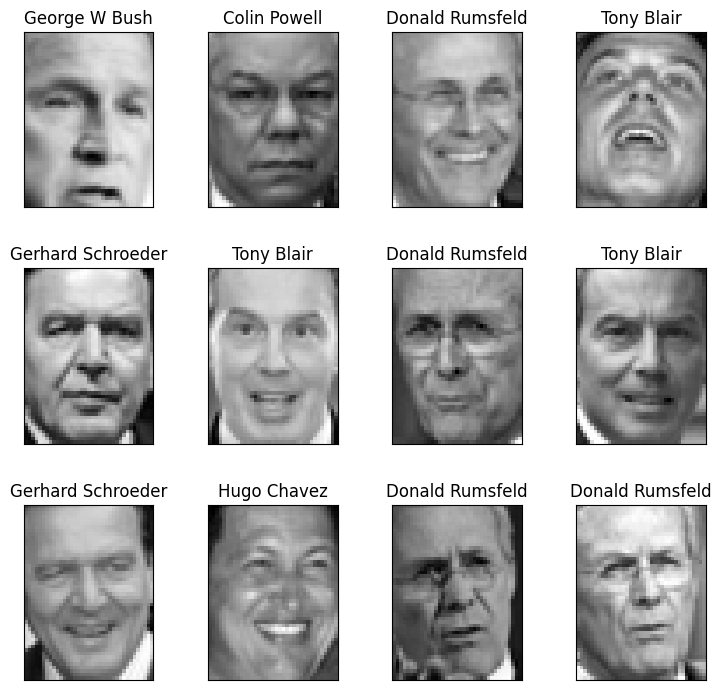

In [3]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

def plot_gallery(images: npt.NDArray[np.floating], titles: list[str], h: int, w: int, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits."""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap="gray")
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

sample_faces = X_train[0:13].reshape((13, h, w))
face_titles = ["%s" % target_names[t] for t in y_train]
plot_gallery(sample_faces, face_titles, h, w)

### 📝 Task 1.3 Apply dimensionality reduction methods

Now, we can apply different dimensionality reduction methods to the input data. We will compare [Principal Component Analysis](https://scikit-learn.org/stable/modules/decomposition.html#pca) (PCA), [Non-Negative Matrix Factorisation](https://scikit-learn.org/stable/modules/decomposition.html#nmf) (NMF), and [Independent Component Analysis](https://scikit-learn.org/stable/modules/decomposition.html#ica) (ICA).

In [5]:
from sklearn.decomposition import PCA, NMF, FastICA
from time import time

n_components = 50

# PCA
print("Extracting the top %d eigenfaces from %d faces using PCA" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("PCA done in %0.3fs" % (time() - t0))

# NMF
print("Extracting the top non-negative compoments using NMF")
t0 = time()
nmf = NMF(n_components=n_components, init='nndsvda', random_state=0)
X_train_nmf = nmf.fit_transform(X_train)
X_test_nmf = nmf.transform(X_test)
print("NMF done in %0.3fs" % (time() - t0))

# ICA
print("Extracting the top independent components using ICA")
t0 = time()
ica = FastICA(n_components=n_components, random_state=0, max_iter=400, whiten="unit-variance")
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)
print("ICA done in %0.3fs" % (time() - t0))


Extracting the top 50 eigenfaces from 966 faces using PCA
PCA done in 0.098s
Extracting the top non-negative compoments using NMF


/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF done in 2.268s
Extracting the top independent components using ICA
ICA done in 0.527s


### 📝 Task 1.4 Visualise results

We can now visualise the main components learned by each of the dimensionlity reduction methods we just trained. Each of them will have the same dimension as a face, so we can reuse the `plot_gallery` functions that we previously wrote.

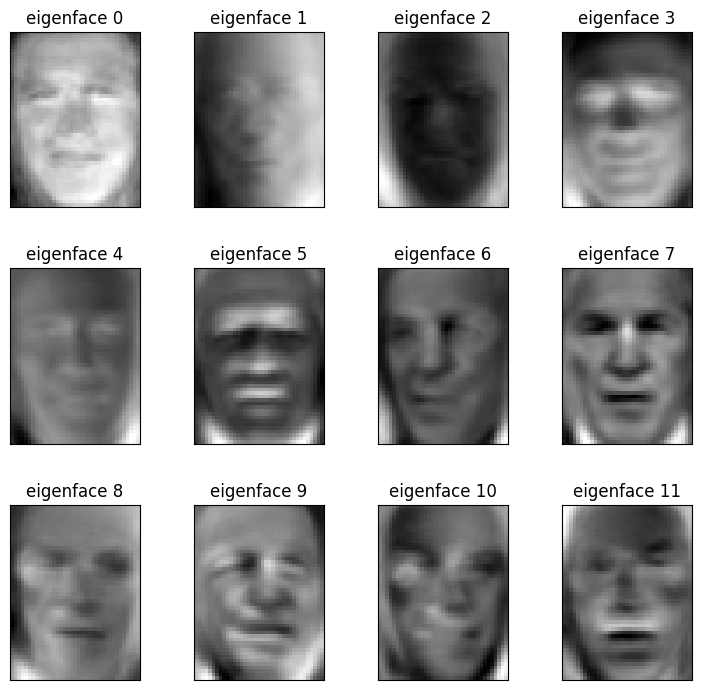

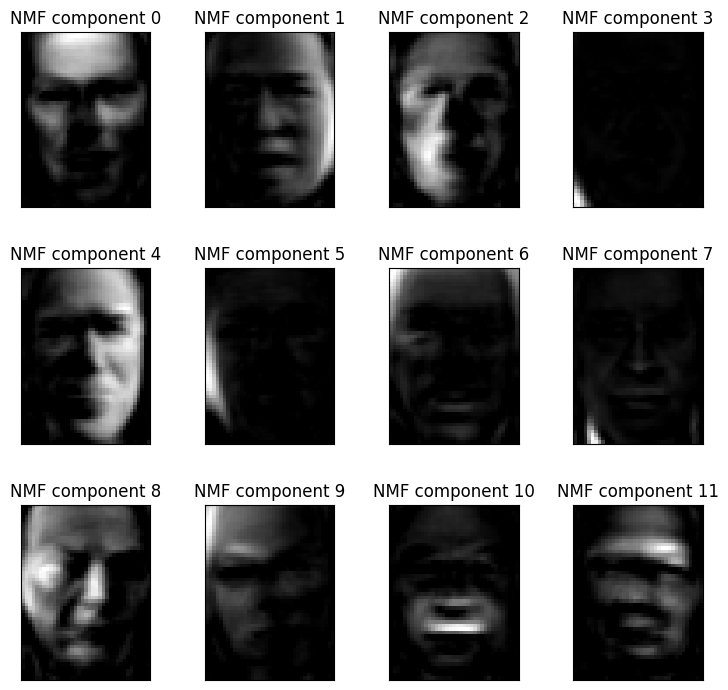

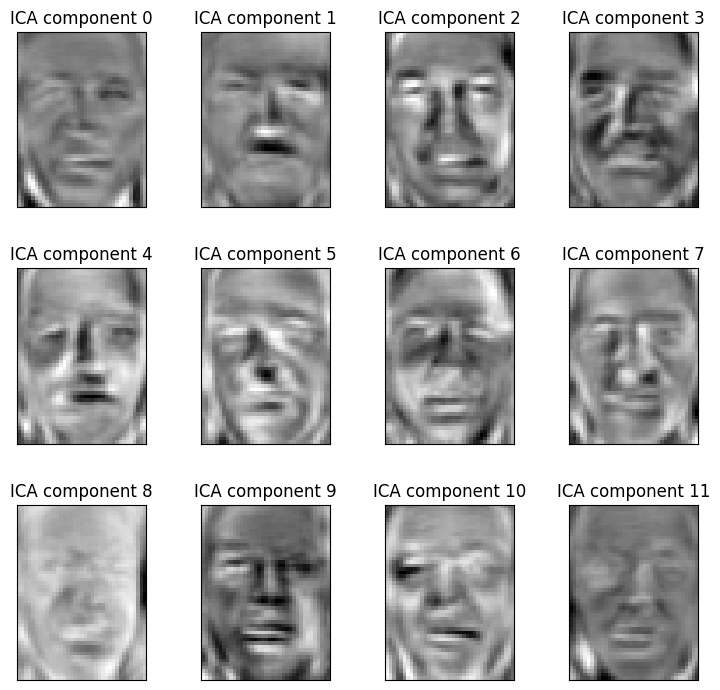

In [6]:
# Visualize PCA components
sample_faces = pca.components_.reshape((n_components, h, w))
face_titles = ["eigenface %d" % i for i in range(sample_faces.shape[0])]
plot_gallery(sample_faces, face_titles, h, w)

# Visualize NMF components
nmf_faces = nmf.components_.reshape((n_components, h, w))
nmf_titles = ["NMF component %d" % i for i in range(nmf_faces.shape[0])]
plot_gallery(nmf_faces, nmf_titles, h, w)

# Visualize ICA components
ica_faces = ica.components_.reshape((n_components, h, w))
ica_titles = ["ICA component %d" % i for i in range(ica_faces.shape[0])]
plot_gallery(ica_faces, ica_titles, h, w)

### 📝 Task 1.5 Train SVM Classifier using the Components Extraced by the Different Method and Evaluate

Finally, we train an SVM classifier to predict a person's name given a picture of their face. How does the classifier's performance change when using no dimensionality reduction compared to the methods trained above?

Fitting the classifier to the training set using no decomposition


/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/janainamourao-miranda/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required f

done in 17.888s
Best estimator found by random search:
SVC(C=12520.653814999461, class_weight='balanced', gamma=0.013981961408994045,
    random_state=0)
Predicting people's names on the test set using no decomposition
done in 0.191s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.87      0.95      0.90       146
Gerhard Schroeder       0.83      0.76      0.79        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.83      0.69      0.76        36

         accuracy                           0.84       322
        macro avg       0.81      0.74      0.77       322
     weighted avg       0.84      0.84      0.83       322



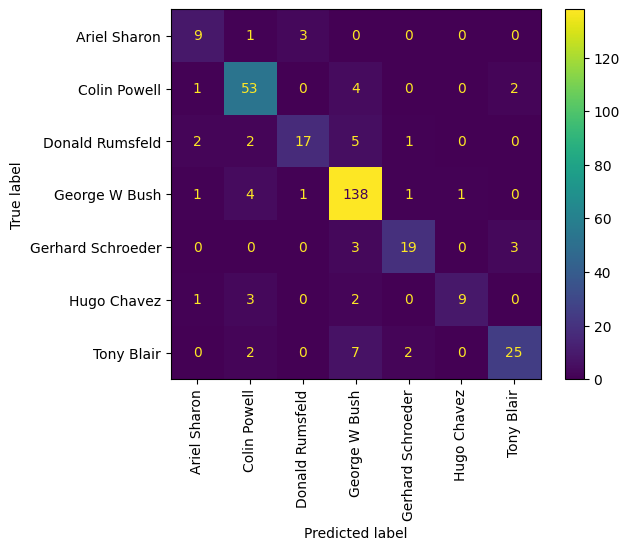

Fitting the classifier to the training set using PCA
done in 0.941s
Best estimator found by random search:
SVC(C=12520.653814999461, class_weight='balanced', gamma=0.013981961408994045,
    random_state=0)
Predicting people's names on the test set using PCA
done in 0.046s
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.77      0.74        13
     Colin Powell       0.83      0.92      0.87        60
  Donald Rumsfeld       0.73      0.59      0.65        27
    George W Bush       0.85      0.92      0.88       146
Gerhard Schroeder       0.78      0.56      0.65        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.75      0.67      0.71        36

         accuracy                           0.81       322
        macro avg       0.77      0.72      0.74       322
     weighted avg       0.81      0.81      0.81       322



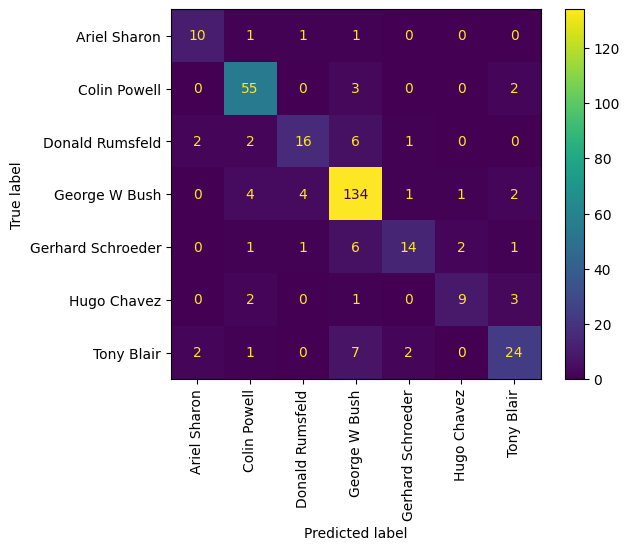

Fitting the classifier to the training set using NMF
done in 1.177s
Best estimator found by random search:
SVC(C=36000.911929116075, class_weight='balanced', gamma=0.040741446541662306,
    random_state=0)
Predicting people's names on the test set using NMF
done in 0.043s
                   precision    recall  f1-score   support

     Ariel Sharon       0.32      0.69      0.44        13
     Colin Powell       0.76      0.75      0.76        60
  Donald Rumsfeld       0.39      0.67      0.49        27
    George W Bush       0.92      0.73      0.81       146
Gerhard Schroeder       0.55      0.68      0.61        25
      Hugo Chavez       0.60      0.60      0.60        15
       Tony Blair       0.79      0.61      0.69        36

         accuracy                           0.70       322
        macro avg       0.62      0.68      0.63       322
     weighted avg       0.76      0.70      0.72       322



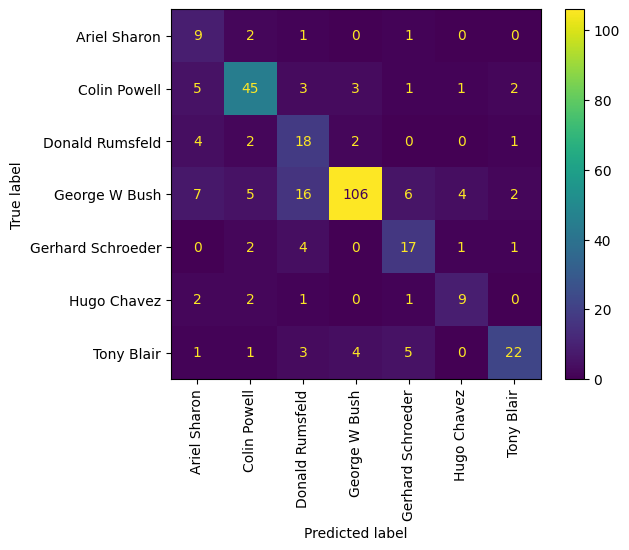

Fitting the classifier to the training set using ICA
done in 0.928s
Best estimator found by random search:
SVC(C=12520.653814999461, class_weight='balanced', gamma=0.013981961408994045,
    random_state=0)
Predicting people's names on the test set using ICA
done in 0.039s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.82      0.92      0.87        60
  Donald Rumsfeld       0.70      0.59      0.64        27
    George W Bush       0.87      0.92      0.89       146
Gerhard Schroeder       0.76      0.64      0.70        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.77      0.67      0.72        36

         accuracy                           0.82       322
        macro avg       0.77      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



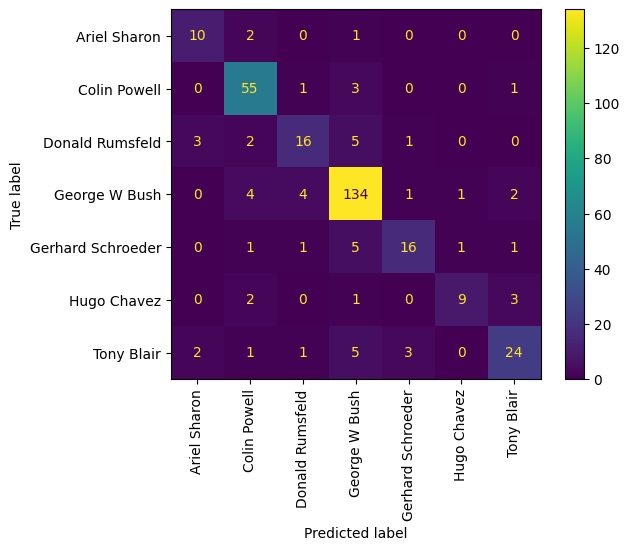

In [7]:
from scipy.stats import loguniform
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

def train_and_evaluate(X_train, X_test, y_train, y_test, method_name):
    print(f"Fitting the classifier to the training set using {method_name}")
    t0 = time()
    param_grid = {"C": loguniform(1e3, 1e5), "gamma": loguniform(1e-4, 1e-1)}
    clf = RandomizedSearchCV(
        SVC(kernel="rbf", class_weight="balanced", random_state=0),
        param_grid,
        n_iter=10,
        n_jobs=-1,
        random_state=0
    )
    clf = clf.fit(X_train, y_train)
    print(f"done in %0.3fs" % (time() - t0))
    print("Best estimator found by random search:")
    print(clf.best_estimator_)

    print(f"Predicting people's names on the test set using {method_name}")
    t0 = time()
    y_pred = clf.predict(X_test)
    print(f"done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=target_names, xticks_rotation='vertical')
    plt.show()

# Train and evaluate on the unmodified data
train_and_evaluate(X_train, X_test, y_train, y_test, "no decomposition")

# Train and evaluate for PCA
train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test, "PCA")

# Train and evaluate for NMF
train_and_evaluate(X_train_nmf, X_test_nmf, y_train, y_test, "NMF")

# Train and evaluate for ICA
train_and_evaluate(X_train_ica, X_test_ica, y_train, y_test, "ICA")

### 🗣 Discuss:
- What are the differences in how PCA, NMF, and ICA capture features.
- How do these differences affect the performance of the SVM classifier.

## 👩‍💻 Part 2: OASIS dataset: Cross decomposition methods

In this part, you will learn how to apply cross decomposition methods such as CCA and PLSSVD to find the fundamental relations (or latent dimensions) between two matrices (X and Y) that represent different views of the same data.

We will use the Open Access Series of Imaging Studies (OASIS) dataset, which contains brain Magnetic Resonance Images (MRI) (view 1) and clinical assessments (view 2) of 416 subjects aged 18 to 96. The brain images have been summarized into 116 Regions of Interest (ROIs) using the Automated Anatomical Labeling (AAL) atlas (https://www.gin.cnrs.fr/en/tools/aal/). The clinical data consist of tabular data including gender, age, education and two clinical questionnairs, the mini mental state examination (MMSE) and the clinical dementia rating (CDR). The goal is to explore how these two views are related.

It is important to note that there are 2 groups in the OASIS data: healthy subjects, and those with dementia. The `OASIS_labels.csv` file contains the label for each subject.

### Import libraries and load data

First, we need to import some libraries and load the data from CSV files.

In [12]:
import pandas as pd

labels = pd.read_csv("./OASIS_labels.csv")
brain_roi = pd.read_csv("./OASIS_view1_ROI.csv")
clinical = pd.read_csv("./OASIS_view2_clinical.csv")
roi_names = pd.read_csv("./AAL_ROI_names.csv", header=None).squeeze()

### Data preprocessing

Next, we need to do some preprocessing on the data. We will drop some columns that are not relevant for our analysis, such as subject ID, handness, etc. We will also normalize each view by subtracting its mean and dividing by its standard deviation.

In [13]:
from sklearn.preprocessing import StandardScaler

brain_roi = brain_roi.drop(["Subject ID"], axis=1)
clinical = clinical.drop(["Subject ID"], axis=1)

# One-hot encode the "Gender" column and drop the first column to avoid multicollinearity
clinical = pd.get_dummies(clinical, columns=["Gender"], drop_first=True)

# Fill nans with mean values
brain_roi = brain_roi.fillna(brain_roi.mean(numeric_only=True))
clinical = clinical.fillna(clinical.mean(numeric_only=True))

brain_roi.columns = roi_names

# Convert labels to numbers before the split
label_dict = {"Demented": 0, "Nondemented": 1}
labels["Group"] = labels["Group"].map(label_dict)

# Split the data and labels into training and testing sets
train_brain_roi, test_brain_roi, train_clinical, test_clinical, train_labels, test_labels = train_test_split(
    brain_roi, clinical, labels["Group"], test_size=0.3, random_state=42)

# Apply StandardScaler separately to training and testing sets to avoid data leakage
scaler_brain = StandardScaler()
train_brain_roi = scaler_brain.fit_transform(train_brain_roi)
test_brain_roi = scaler_brain.transform(test_brain_roi)

scaler_clinical = StandardScaler()
train_clinical = scaler_clinical.fit_transform(train_clinical)
test_clinical = scaler_clinical.transform(test_clinical)

In [14]:
brain_roi

,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,...,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
0,0.328376,0.310736,0.331466,0.365400,0.473319,0.513658,0.365515,0.426603,0.435912,0.491478,...,0.158964,0.117107,0.343077,0.332691,0.476891,0.525261,0.610925,0.692715,0.666304,0.212833
1,0.265462,0.284931,0.280695,0.311896,0.317296,0.329173,0.288063,0.330815,0.278311,0.296520,...,0.149029,0.131028,0.329705,0.320142,0.462999,0.478867,0.563096,0.683033,0.587780,0.198033
2,0.254751,0.257339,0.292834,0.264672,0.398141,0.351934,0.317767,0.328207,0.358854,0.375535,...,0.137343,0.118622,0.379502,0.330435,0.380093,0.441531,0.554831,0.641267,0.561768,0.213696
3,0.280047,0.297505,0.291329,0.323008,0.429695,0.414882,0.343897,0.357219,0.412683,0.423509,...,0.127153,0.134607,0.309793,0.273754,0.345968,0.414761,0.449908,0.512534,0.506002,0.157815
4,0.247047,0.241039,0.245281,0.240963,0.348234,0.325550,0.276698,0.275589,0.355991,0.335164,...,0.132554,0.109551,0.288043,0.255369,0.305809,0.338685,0.404975,0.449699,0.381659,0.154141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.283958,0.283804,0.274866,0.275195,0.436282,0.429009,0.310347,0.371561,0.392171,0.405194,...,0.168741,0.150855,0.355952,0.340494,0.468567,0.547288,0.661266,0.681692,0.561343,0.204061
96,0.219749,0.229720,0.231304,0.236867,0.311941,0.290046,0.240077,0.255363,0.284920,0.335230,...,0.129547,0.129192,0.367391,0.337985,0.400780,0.429753,0.546856,0.561667,0.460930,0.187182
97,0.260072,0.245813,0.275967,0.263345,0.363978,0.356836,0.294807,0.303855,0.345023,0.368028,...,0.100847,0.105040,0.311794,0.314821,0.411738,0.452949,0.534124,0.613260,0.545518,0.197639
98,0.307017,0.306713,0.242192,0.303062,0.371719,0.372836,0.327543,0.367935,0.379560,0.388705,...,0.104170,0.122919,0.292791,0.264992,0.319118,0.369786,0.451831,0.471996,0.432581,0.164918


In [15]:
clinical

,Age,EDUC,MMSE,CDR,Gender_M
0,87,14,27,0.0,True
1,80,12,28,0.0,True
2,71,16,28,0.5,True
3,66,12,30,0.5,False
4,81,12,30,0.0,False
...,...,...,...,...,...
95,68,14,26,0.0,True
96,74,12,26,0.5,False
97,66,13,30,0.0,False
98,72,16,24,0.5,False


### Cross decomposition methods

Now we are ready to apply cross decomposition methods to find the relations between the two views. We will use three methods: CCA, regularised CCA and PLSSVD.

CCA finds linear combinations of X and Y that have maximum correlation. It can be seen as a generalization of PCA for two sets of variables.

Regularised CCA adds a regularisation term to prevent overfitting on the training set.

PLSSVD finds linear combinations of X and Y that have maximum covariance. It can be seen as a generalization of SVD for two sets of variables.

For both methods, we need to specify the number of components that we want to extract from each view. This parameter controls the dimensionality of the latent space.

We will use n_components=2 for both methods. You can try different values later and see how they affect the results.

For further comparison, apply PCA to the brain_roi data with 2 components in order to see if combining the modalities changes the latent space.

### Task 2.1 - Apply CCA to the brain and clinical dataset and plot the weights for the two first CCA components (brain and clinical)

We will use [`cca-zoo`](https://cca-zoo.readthedocs.io/en/latest/#) to carry out the calculations. It's a library which offers support for many different algorithms, including a regularised version of CCA which is not present in `sklearn`.

In [17]:
from cca_zoo.linear import CCA
from cca_zoo._base import _BaseModel

def fit_transform_cross_decomposition(model: _BaseModel):
    # Fit CCA model on X (brain_roi) and Y (clinical)
    model.fit((train_brain_roi, train_clinical))

    # Transform X and Y into their latent representations using CCA
    X_train, Y_train = model.transform((train_brain_roi, train_clinical))
    X_test, Y_test = model.transform((test_brain_roi, test_clinical))

    return X_train, X_test, Y_train, Y_test

n_components = 2
cca = CCA(latent_dimensions=n_components, random_state=0)
X_c_train, X_c_test, Y_c_train, Y_c_test = fit_transform_cross_decomposition(cca)

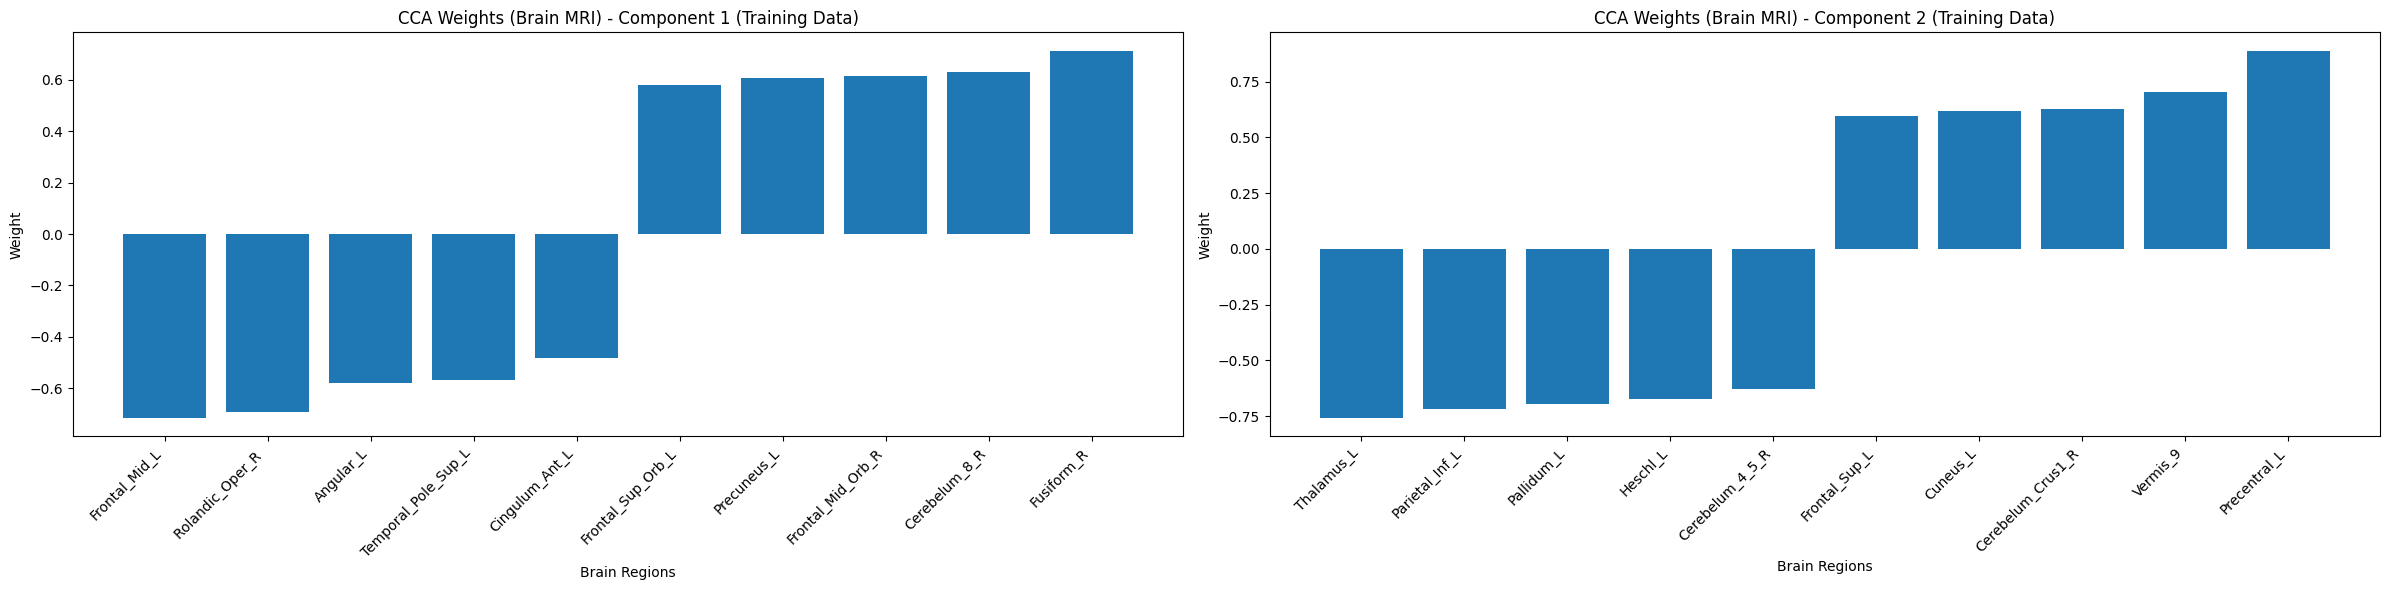

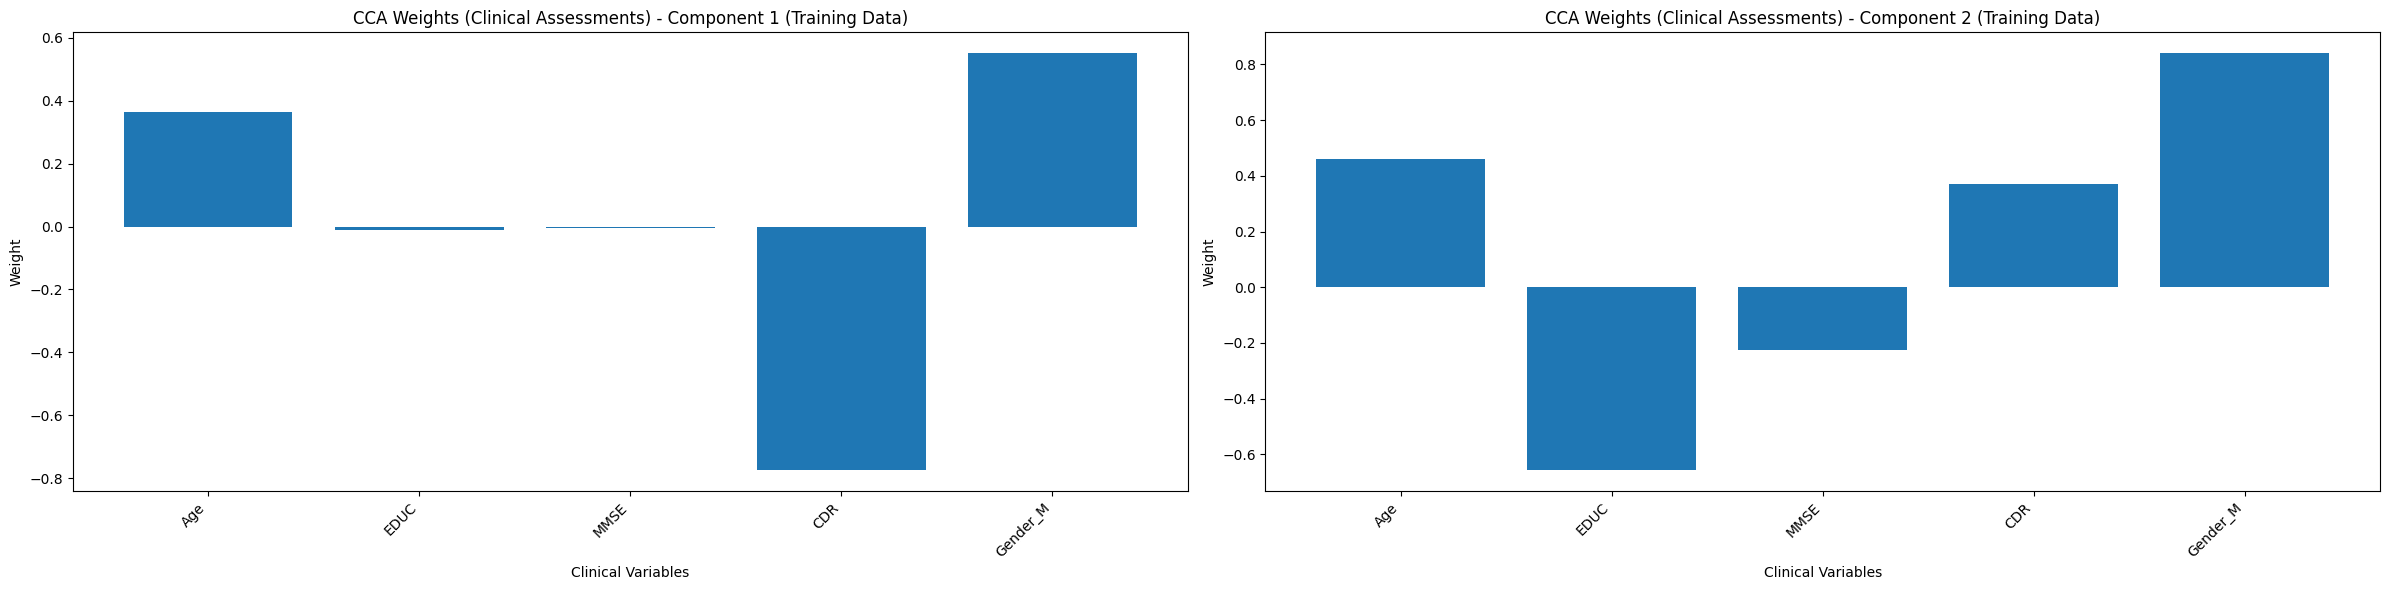

In [18]:
# Function to select top N positive and negative coefficients
def select_top_coefficients(weights, names, n=5):
    indices_pos = np.argsort(weights)[-n:]  # Indices of top n positive weights
    indices_neg = np.argsort(weights)[:n]   # Indices of top n negative weights
    indices = np.concatenate([indices_neg, indices_pos])
    return [names[i] for i in indices], weights[indices]

def plot_brain_roi_weights(brain_weights):
    brain_region_names = brain_roi.columns.tolist()

    # Plotting adjustments for brain weights
    plt.figure(figsize=(24, 6))
    for i in range(2):  # Looping over the first two components
        names, top_weights = select_top_coefficients(brain_weights[:, i], brain_region_names)
        plt.subplot(1, 2, i+1)
        plt.bar(range(len(names)), top_weights, align="center")
        plt.xticks(range(len(names)), names, rotation=45, ha="right")  # Rotate names for better readability
        plt.xlabel('Brain Regions')
        plt.ylabel('Weight')
        plt.title(f'CCA Weights (Brain MRI) - Component {i+1} (Training Data)')

    plt.tight_layout()
    plt.show()

def plot_clinical_variables_weights(clinical_weights):
    clinical_variable_names = clinical.columns.tolist()

    # Plotting adjustments for clinical weights, potentially keeping all components
    plt.figure(figsize=(24, 6))
    for i in range(2):  # Looping over the first two components
        plt.subplot(1, 2, i+1)
        plt.bar(range(len(clinical_variable_names)), clinical_weights[:, i], align="center")
        plt.xticks(range(len(clinical_variable_names)), clinical_variable_names, rotation=45, ha="right")
        plt.xlabel('Clinical Variables')
        plt.ylabel('Weight')
        plt.title(f'CCA Weights (Clinical Assessments) - Component {i+1} (Training Data)')

    plt.tight_layout()
    plt.show()

brain_weights = cca.weights_[0]
clinical_weights = cca.weights_[1]

plot_brain_roi_weights(brain_weights)
plot_clinical_variables_weights(clinical_weights)

### Task 2.2 -  Plot the CCA latent space for the top 2 components

Correlation for Training Latent Dimension 1: 1.000
Correlation for Testing Latent Dimension 1: 0.152
Correlation for Training Latent Dimension 2: 1.000
Correlation for Testing Latent Dimension 2: 0.148


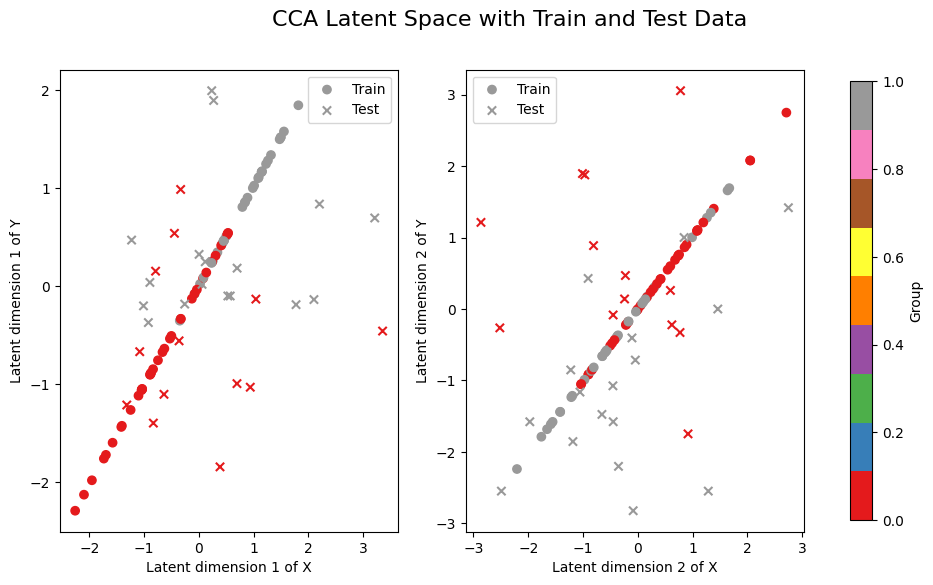

In [19]:
def plot_correlation(X_train, X_test, Y_train, Y_test, train_labels, test_labels, n_components):
    # Plot the latent dimensions for CCA
    fig, axes = plt.subplots(1, n_components, figsize=(12, 6), squeeze=False)
    axes = axes.ravel()

    train_marker = 'o'  # Circle for training data
    test_marker = 'x'   # Cross for testing data

    for i in range(n_components):
        # Plot for training data with label information
        scatter_train = axes[i].scatter(X_train[:, i], Y_train[:, i], c=train_labels, cmap="Set1", marker=train_marker, label='Train')
        # Plot for testing data with label information
        scatter_test = axes[i].scatter(X_test[:, i], Y_test[:, i], c=test_labels, cmap="Set1", marker=test_marker, label='Test')

        axes[i].set_xlabel(f"Latent dimension {i+1} of X")
        axes[i].set_ylabel(f"Latent dimension {i+1} of Y")
        axes[i].legend()

        # Calculate and store correlation for each component
        train_corr = np.corrcoef(X_train[:, i], Y_train[:, i])[0, 1]
        test_corr = np.corrcoef(X_c_test[:, i], Y_test[:, i])[0, 1]

        # Optionally print the correlations
        print(f"Correlation for Training Latent Dimension {i+1}: {train_corr:.3f}")
        print(f"Correlation for Testing Latent Dimension {i+1}: {test_corr:.3f}")

    # Create a color bar for the 'Group' label
    cbar = plt.colorbar(scatter_train, ax=axes.ravel().tolist(), shrink=0.95)
    cbar.set_label('Group')

    fig.suptitle("CCA Latent Space with Train and Test Data", fontsize=16)
    plt.show()

plot_correlation(X_c_train, X_c_test, Y_c_train, Y_c_test, train_labels, test_labels, n_components)

### Task 2.3 - Show the same plots, but obtained by applying regularised CCA to the brain and clinical dataset

In [20]:
from cca_zoo.linear import rCCA

rcca = rCCA(latent_dimensions=n_components, random_state=0, c=0.1)
X_rc_train, X_rc_test, Y_rc_train, Y_rc_test = fit_transform_cross_decomposition(rcca)

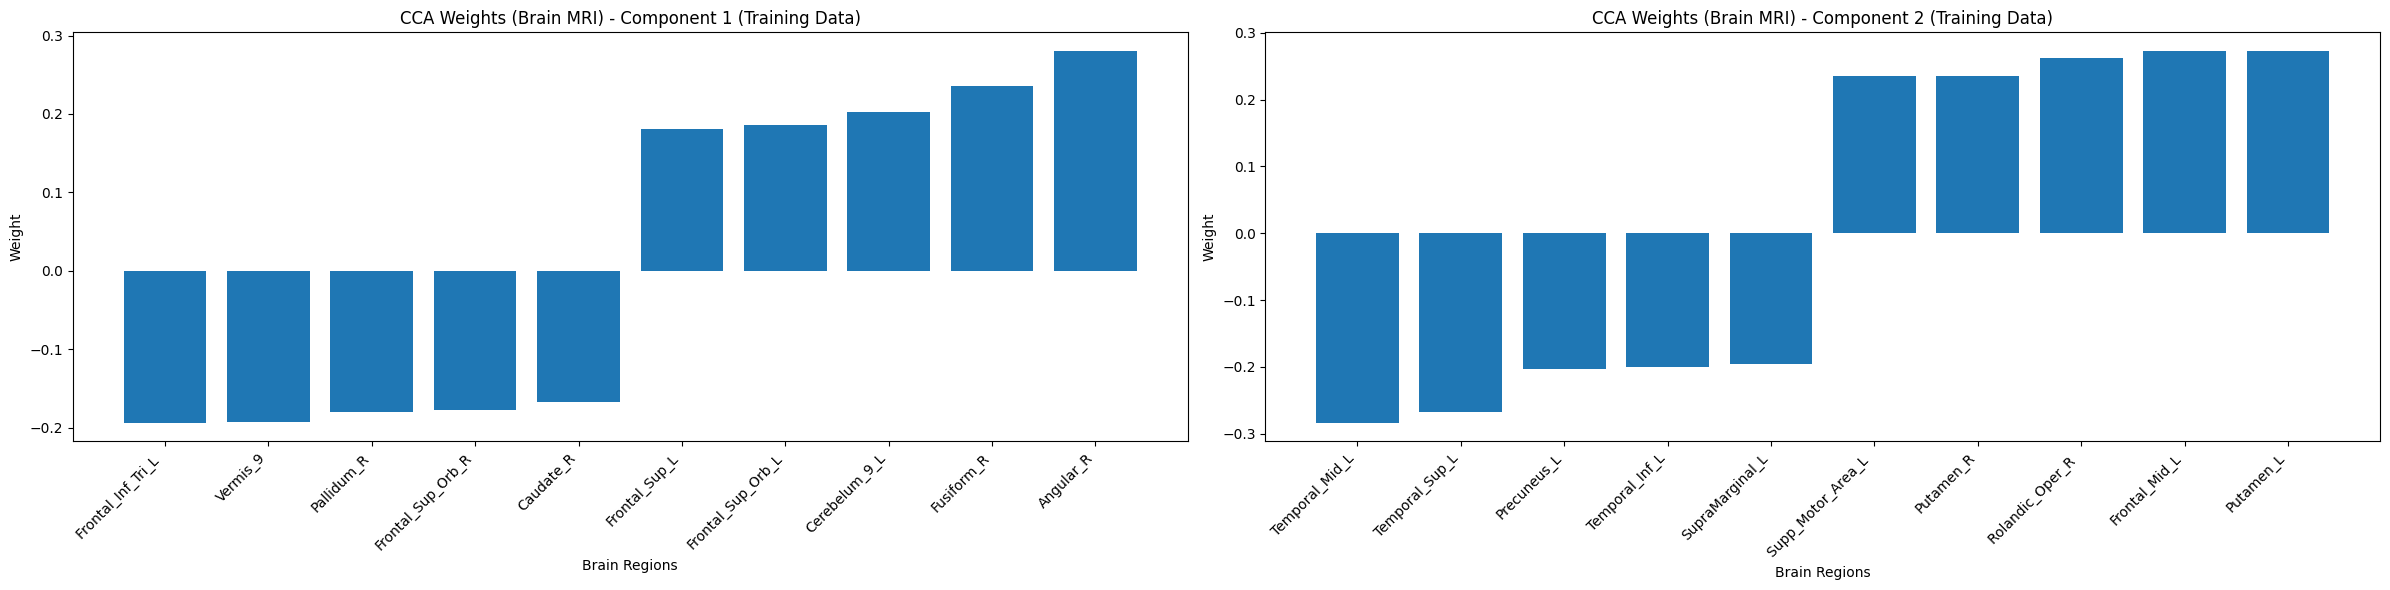

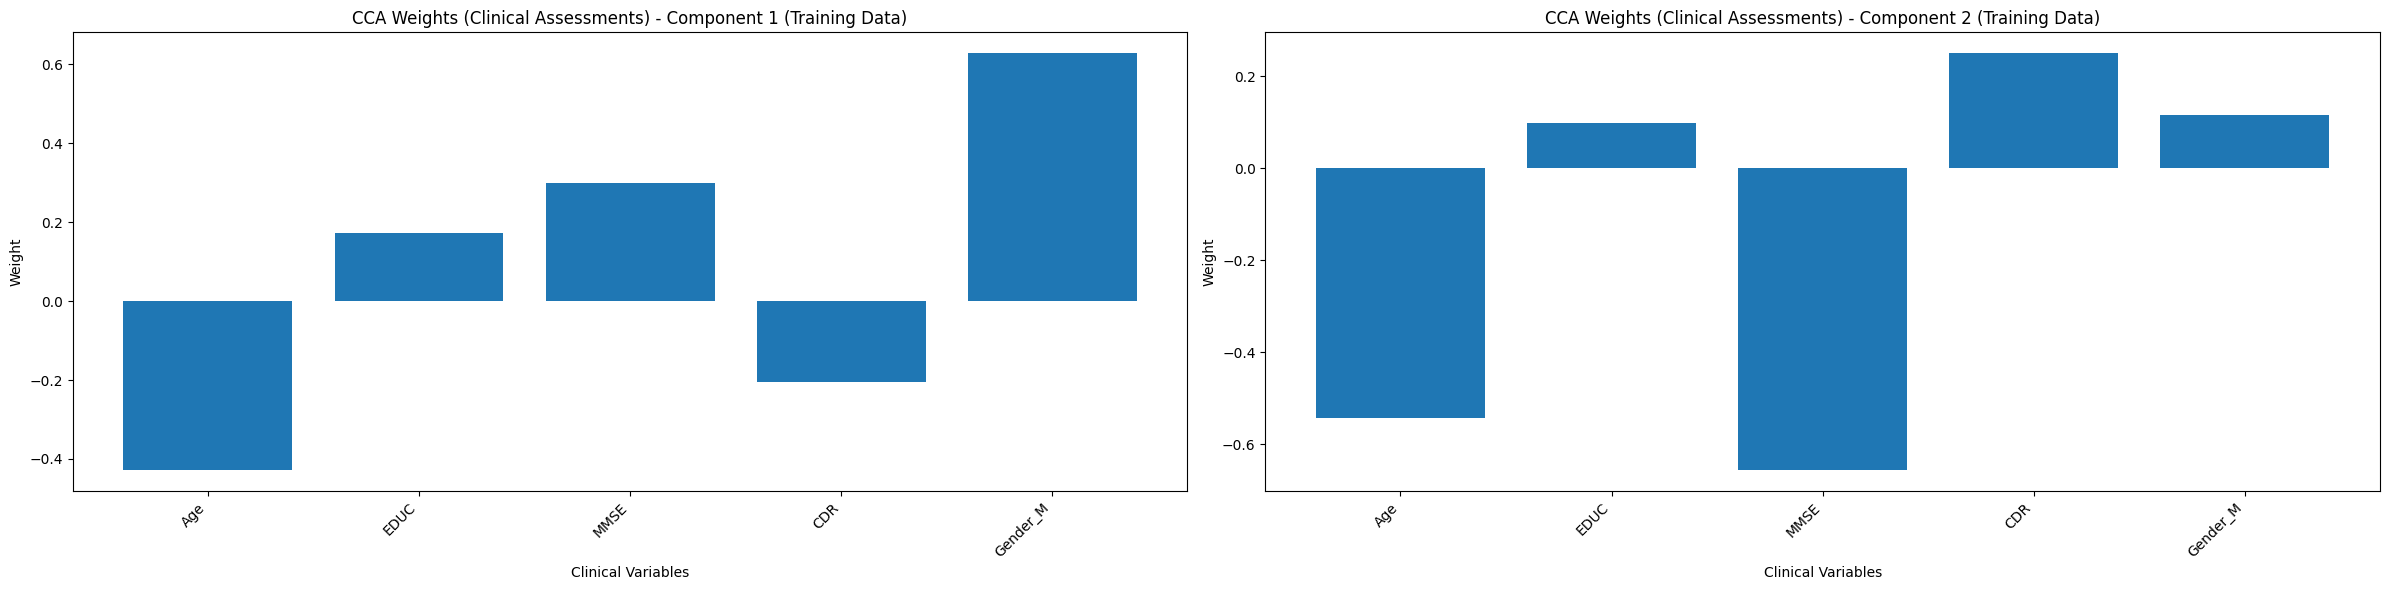

In [21]:
plot_brain_roi_weights(rcca.weights_[0])
plot_clinical_variables_weights(rcca.weights_[1])

Correlation for Training Latent Dimension 1: 0.950
Correlation for Testing Latent Dimension 1: 0.496
Correlation for Training Latent Dimension 2: 0.950
Correlation for Testing Latent Dimension 2: -0.257


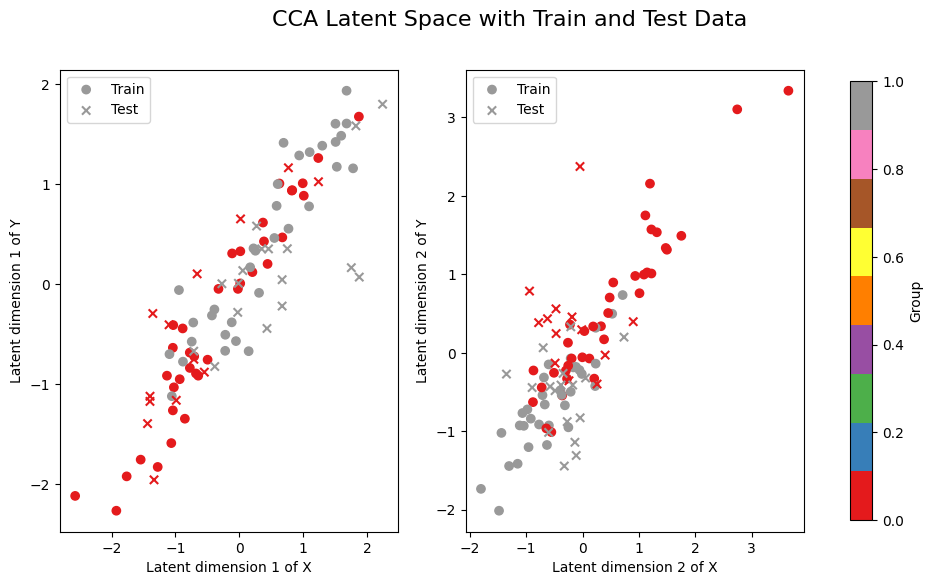

In [22]:
plot_correlation(X_rc_train, X_rc_test, Y_rc_train, Y_rc_test, train_labels, test_labels, n_components)

### Task 2.4 - Show the same plots, but obtained by applying PLSSVD to the brain and clinical dataset

In [23]:
from cca_zoo.linear import PLS

plssvd = PLS(latent_dimensions=n_components, random_state=0)
X_p_train, X_p_test, Y_p_train, Y_p_test = fit_transform_cross_decomposition(plssvd)

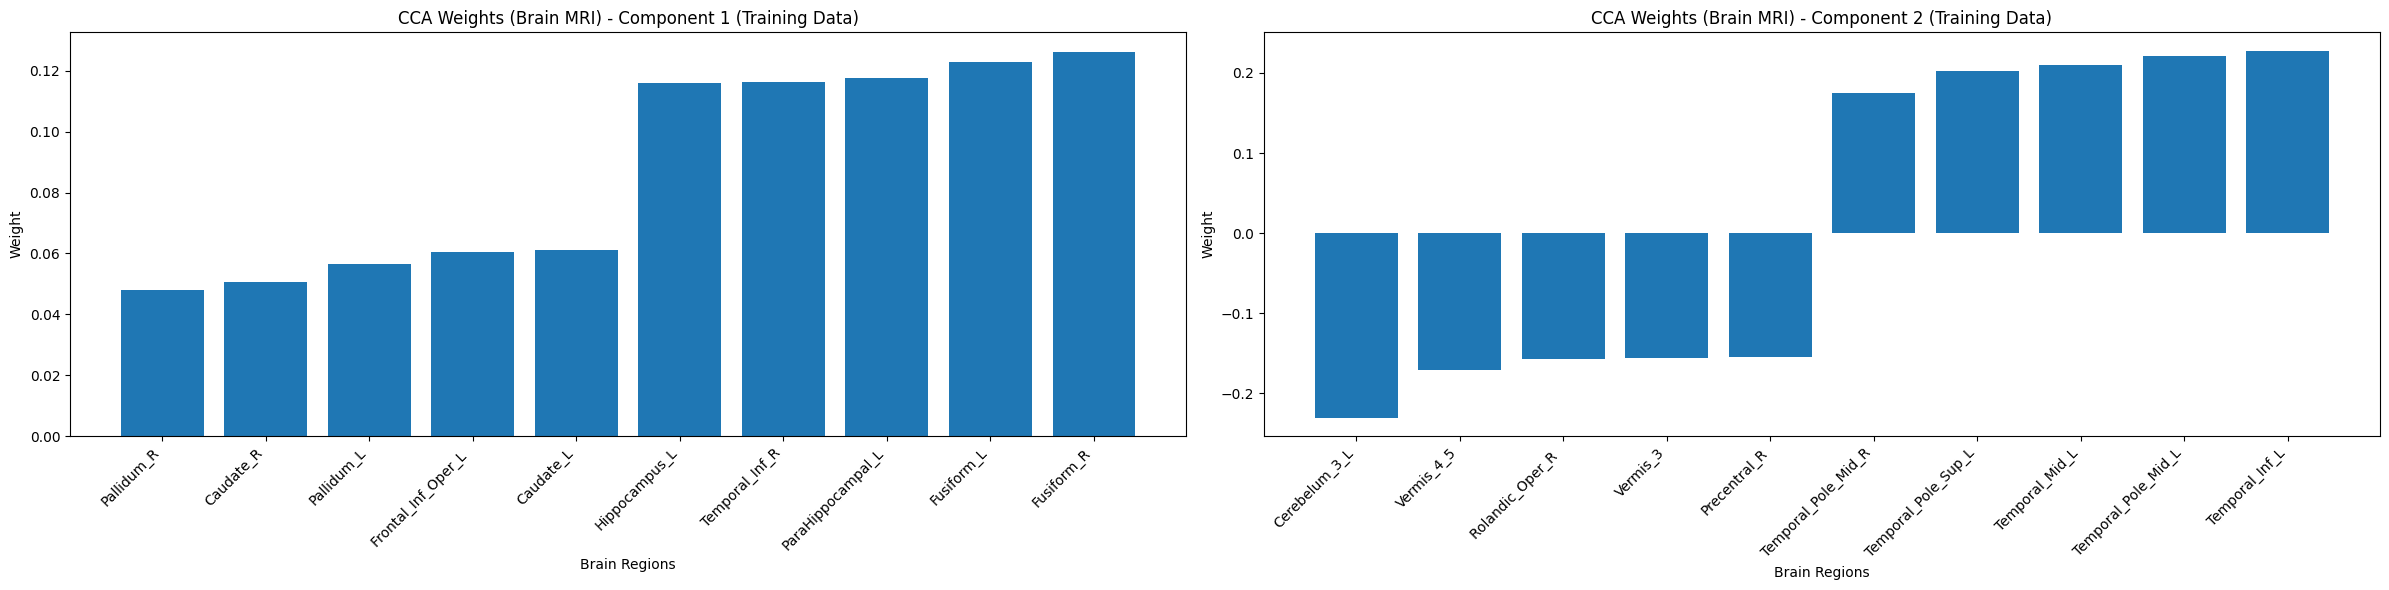

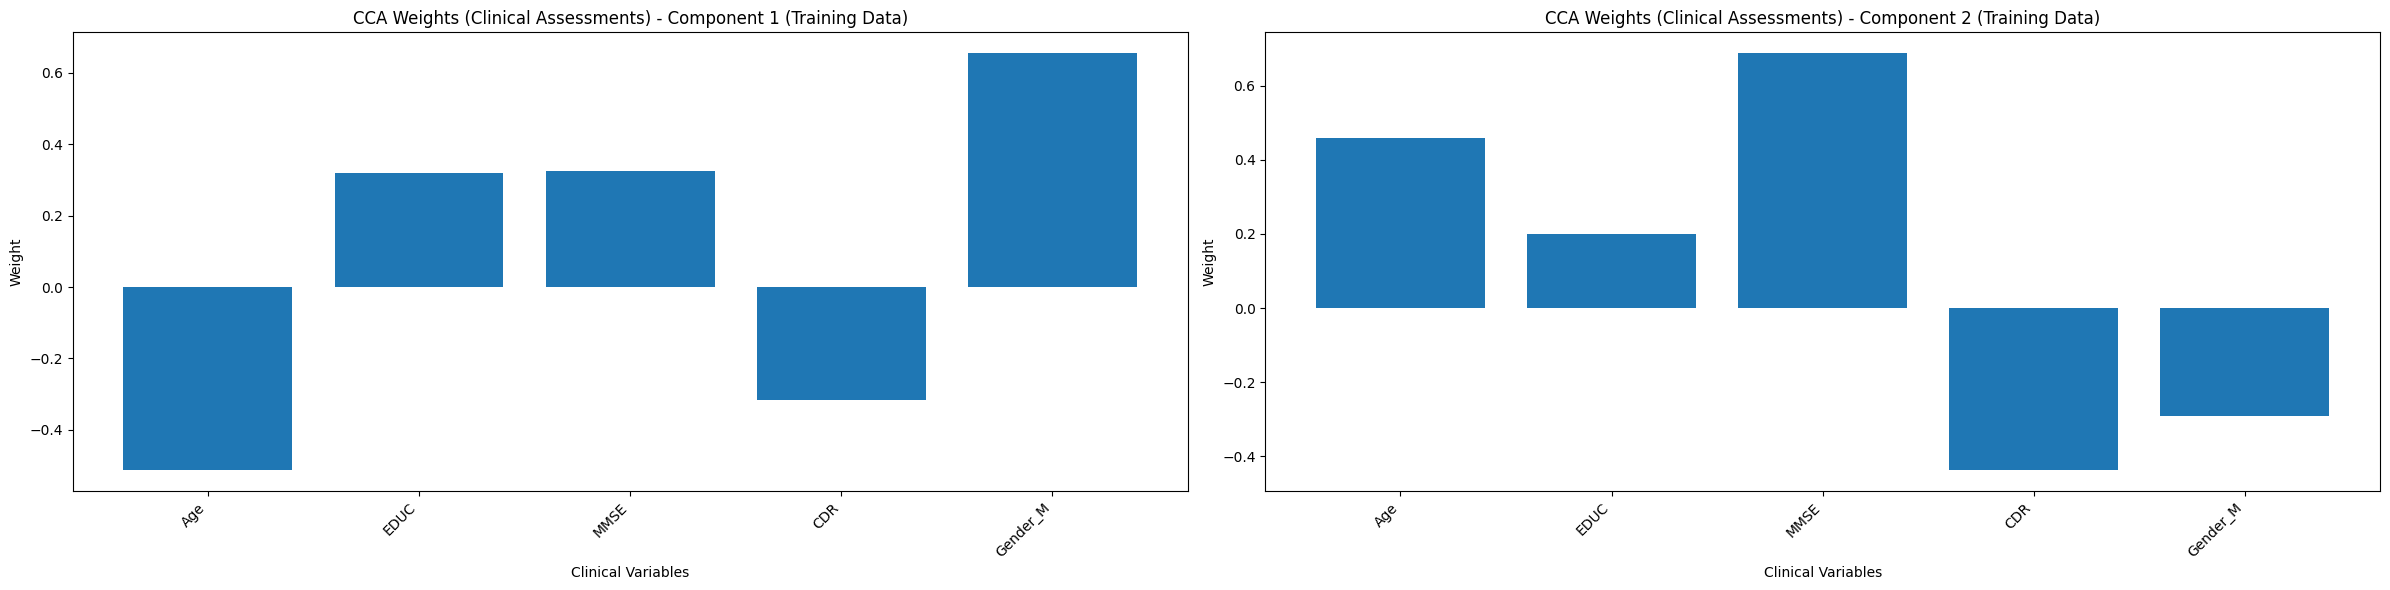

In [24]:
# Extract PLSSVD weights for brain MRI and clinical assessments
brain_weights_pls = plssvd.weights_[0]
clinical_weights_pls = plssvd.weights_[1]

plot_brain_roi_weights(brain_weights_pls)
plot_clinical_variables_weights(clinical_weights_pls)

Correlation for Training Latent Dimension 1: 0.707
Correlation for Testing Latent Dimension 1: 0.473
Correlation for Training Latent Dimension 2: 0.615
Correlation for Testing Latent Dimension 2: 0.160


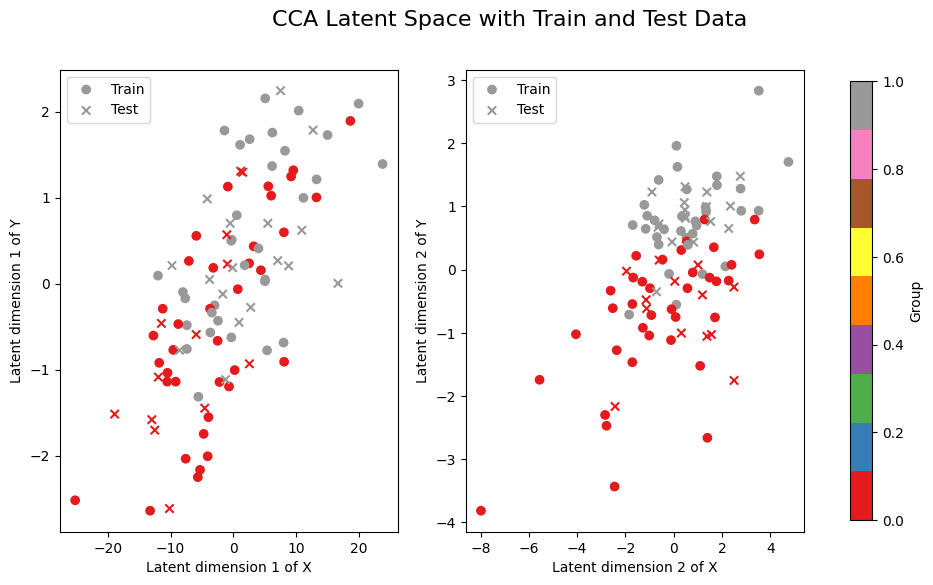

In [25]:
plot_correlation(X_p_train, X_p_test, Y_p_train, Y_p_test, train_labels, test_labels, n_components)

### Task 2.5 - Now apply PCA to the brain and clinical data idependently and plot both:
- The first two PCA components
- The PCA latent space for the two first components

In [26]:
# Number of components for PCA
PCA_n_components = 2

# PCA for brain data
pca_brain = PCA(n_components=PCA_n_components)
pca_brain.fit(train_brain_roi)
X_brain_pca = pca_brain.transform(train_brain_roi)

#### Plotting PCA components (brain data)

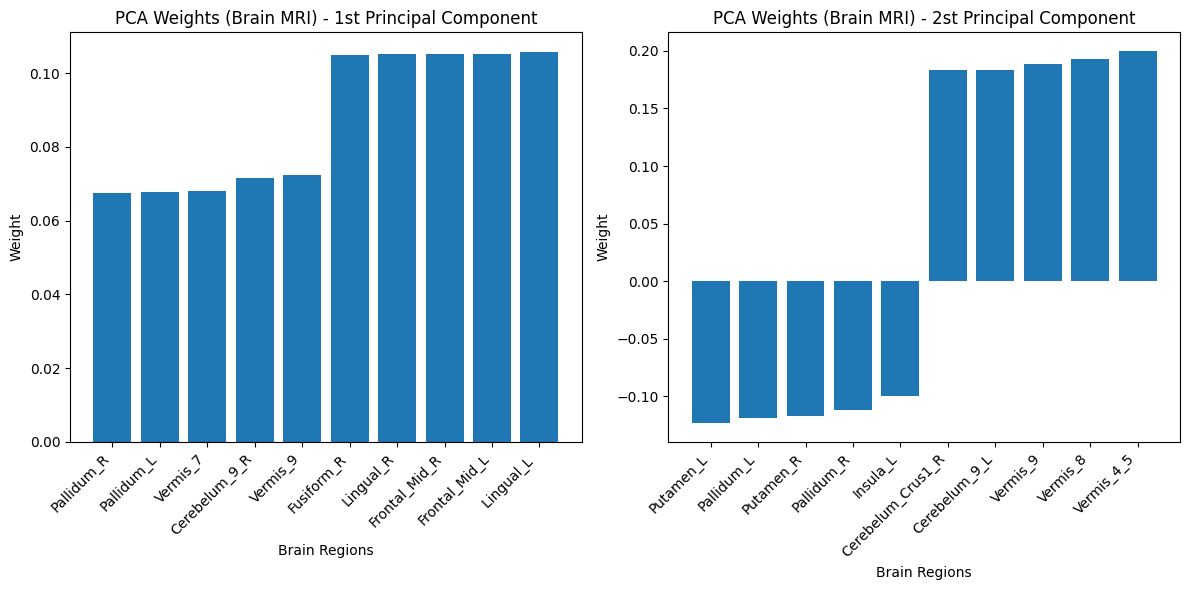

In [27]:
brain_pca_weights = pca_brain.components_

brain_region_names = brain_roi.columns.tolist()

# Adjust plots for brain PCA weights with feature names
plt.figure(figsize=(12, 6))
for i in range(2):  # Looping over the first two principal components
    names, top_weights = select_top_coefficients(brain_pca_weights[i], brain_region_names)
    plt.subplot(1, 2, i+1)
    plt.bar(names, top_weights, align="center")
    plt.xticks(rotation=45, ha="right")  # Rotate names for better readability
    plt.xlabel('Brain Regions')
    plt.ylabel('Weight')
    plt.title(f'PCA Weights (Brain MRI) - {i+1}st Principal Component')

plt.tight_layout()
plt.show()


#### Plotting PCA latent components (brain data)

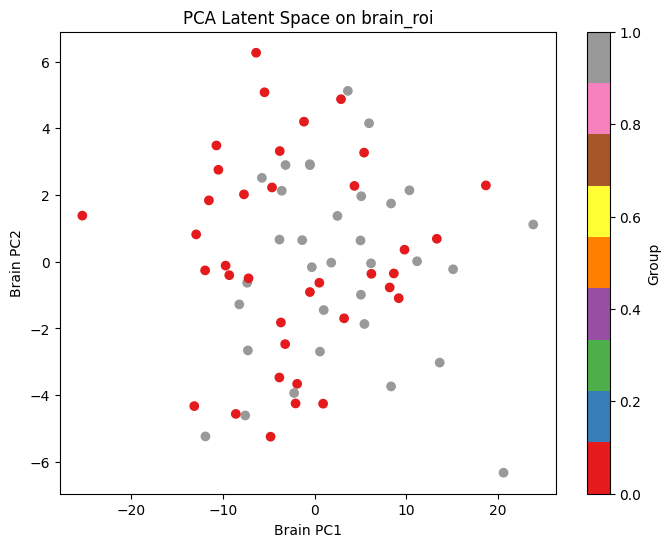

In [28]:
# Plot brain principal components as a scatter plot
plt.figure(figsize=(8, 6))
# Use train_labels directly if it's correctly formatted as a Series or array
plt.scatter(X_brain_pca[:, 0], X_brain_pca[:, 1], c=train_labels, cmap='Set1')
plt.xlabel("Brain PC1")
plt.ylabel("Brain PC2")
plt.title("PCA Latent Space on brain_roi")
plt.colorbar(label='Group')
plt.show()

#### Plotting PCA components (clinical data)

In [29]:
# Perform PCA on clinical variables
PCA_n_components = 2

pca_clinical = PCA(n_components=PCA_n_components)
pca_clinical.fit(train_clinical)
X_clinical_pca = pca_clinical.transform(train_clinical)

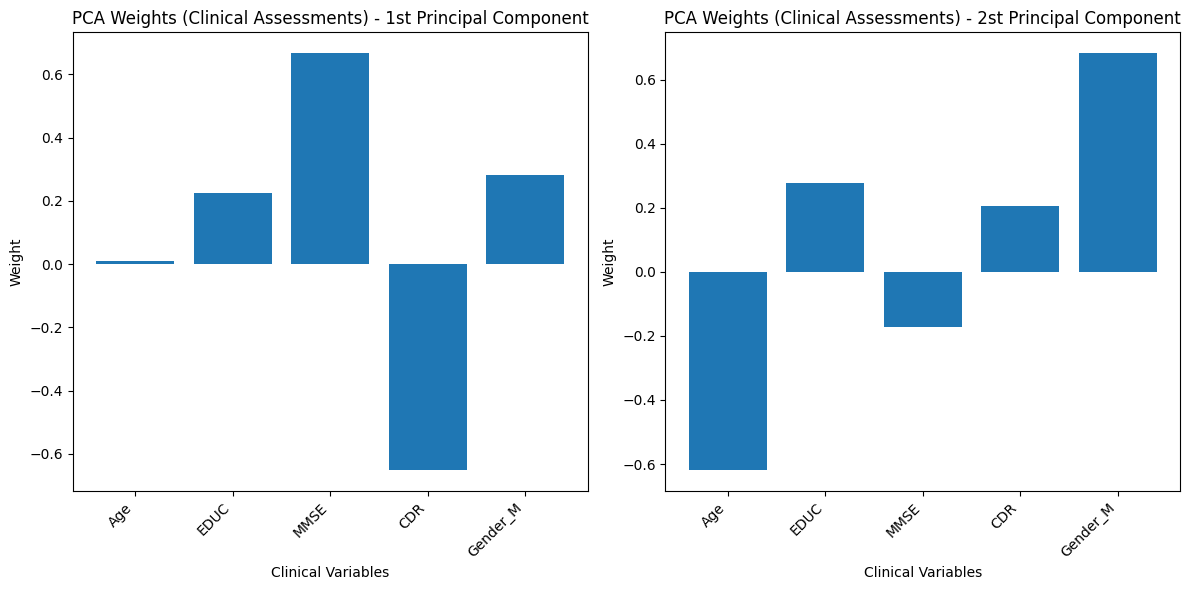

In [30]:
clinical_pca_weights = pca_clinical.components_
clinical_variable_names = clinical.columns.tolist()

# Plotting adjustments for clinical PCA weights with feature names
plt.figure(figsize=(12, 6))
for i in range(2):  # Looping over the first two principal components
    plt.subplot(1, 2, i+1)
    plt.bar(clinical_variable_names, clinical_pca_weights[i], align="center")
    plt.xticks(rotation=45, ha="right")  # Rotate names for better readability
    plt.xlabel('Clinical Variables')
    plt.ylabel('Weight')
    plt.title(f'PCA Weights (Clinical Assessments) - {i+1}st Principal Component')

plt.tight_layout()
plt.show()

#### Plotting PCA latent components (clinical data)

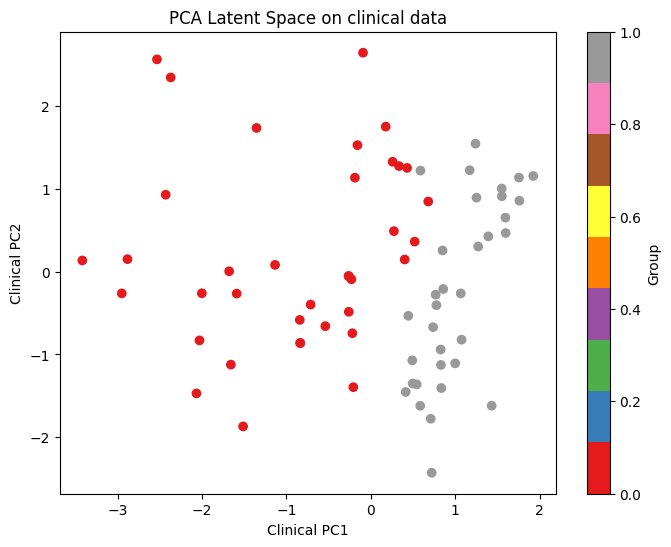

In [31]:
# Plot clinical principal components as a scatter plot
plt.figure(figsize=(8, 6))
# Use train_labels directly if it's correctly formatted as a Series or array
plt.scatter(X_clinical_pca[:, 0], X_clinical_pca[:, 1], c=train_labels, cmap='Set1')
plt.xlabel("Clinical PC1")
plt.ylabel("Clinical PC2")
plt.title("PCA Latent Space on clinical data")
plt.colorbar(label='Group')
plt.show()